###  Imports

In [1]:
import sys
import numpy as np
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown, HTML

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm 
import pyvista as pv
from pyvista import examples
from pyvista import set_plot_theme
set_plot_theme('document')

### Data Plotting

In [2]:
def bigPlot(P, Q, pSize, qSize):    
    sourceCloud = pv.PolyData(Q.T)
    destinationCloud = pv.PolyData(P.T)
    plotter = pv.Plotter()
    sargs = dict(height=0.25, vertical=True, position_x=0.05, position_y=0.05)
    plotter.add_text("Point Clouds", font_size=10)
    plotter.add_mesh(sourceCloud, 
                     color='lightblue',
                     point_size = pSize,
                     render_points_as_spheres = True,
                     show_scalar_bar=False,
                     label = 'True Data')

    plotter.add_mesh(destinationCloud, 
                     color='orange',
                     point_size = qSize,
                     render_points_as_spheres = True,
                     show_scalar_bar=False,
                     label='Moved Data')
    plotter.show_grid()
    plotter.add_legend(size = (0.1, 0.1))
    plotter.show()

In [3]:
'''Plot the true and moved data using Matplotlib'''
def plotData(data1, data2, label1, label2, markersize1 = 20, markersize2 = 20):
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.set_title("Point Clouds")

    xdata1 = data1[0, :]
    ydata1 = data1[1, :]
    zdata1 = data1[2, :]
    ax.scatter3D(xdata1, ydata1, zdata1, s= markersize1, label = label1);
    
    xdata2 = data2[0, :]
    ydata2 = data2[1, :]
    zdata2 = data2[2, :]
    ax.scatter3D(xdata2, ydata2, zdata2, s= markersize2, label=label2);
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()

def plotValues(values, label):
    plt.figure(figsize = (10, 4))
    plt.title("Error")
    plt.plot(values, label=label)
    plt.legend()
    plt.grid(True)
    plt.show()

### Data Generation

In [4]:
'''Samples in a cube'''
def generateData(numPoints, angle, shift, scale):
    
    aboutZ = np.array([[cos(angle[2]), -sin(angle[2]), 0], 
                      [sin(angle[2]), cos(angle[2]), 0],
                      [0, 0, 1]])
    aboutY = np.array([[cos(angle[1]), 0, -sin(angle[1])],
                      [0, 1, 0] ,
                      [sin(angle[1]), 0, cos(angle[1])]])
    aboutX = np.array([[1, 0, 0],
                      [0, cos(angle[0]), -sin(angle[0])],
                      [0, sin(angle[0]), cos(angle[0])]])
      
    T = shift
    R = aboutZ.dot(aboutY.dot(aboutX))
    sourceData = np.random.rand(3, numPoints)
    movedData = R.dot(sourceData) + shift
    movedData = movedData*scale
    return sourceData, movedData

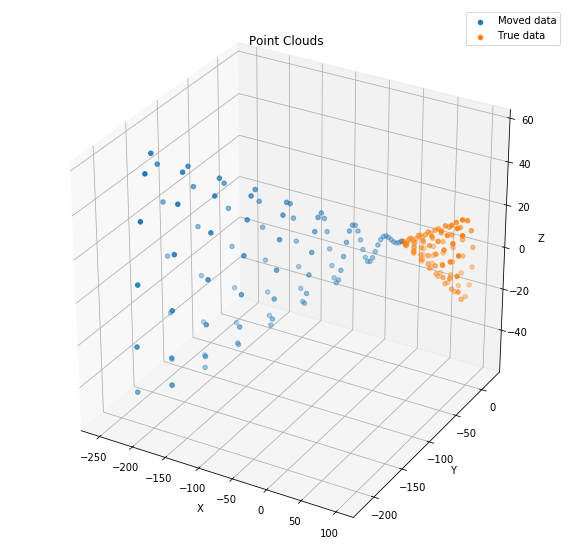

In [46]:
'''Generate data using the sin and cosine functions'''
def generateSpiral(numPoints, angle, shift, scale):
    
    aboutZ = np.array([[cos(angle[2]), -sin(angle[2]), 0], 
                      [sin(angle[2]), cos(angle[2]), 0],
                      [0, 0, 1]])
    aboutY = np.array([[cos(angle[1]), 0, -sin(angle[1])],
                      [0, 1, 0] ,
                      [sin(angle[1]), 0, cos(angle[1])]])
    aboutX = np.array([[1, 0, 0],
                      [0, cos(angle[0]), -sin(angle[0])],
                      [0, sin(angle[0]), cos(angle[0])]])
      
    T = shift
    R = aboutZ.dot(aboutY.dot(aboutX))
    sourceData = np.zeros((3, numPoints))
    sourceData[0, :] = range(0, numPoints)
    sourceData[1, :] = 0.2 * sourceData[0, :] * np.sin(0.5 * sourceData[0, :]) 
    sourceData[2, :] = 0.2 * sourceData[0, :] * np.cos(0.5 * sourceData[0, :]) 
    
    movedData = R.dot(sourceData) + shift
    movedData = movedData*scale
    return sourceData, movedData

'''Assign data to point clouds P and Q''' 
angle = [0, pi, pi/5]
scale = 3
shift = np.array([[0], [0], [0]])
Q, P = generateSpiral(100, angle, shift, scale)

plotData(P, Q, "Moved data", "True data")
plt.show()

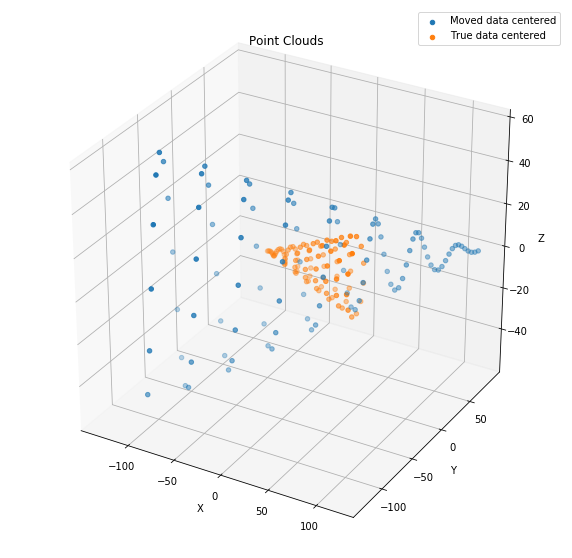

In [6]:
def centerData(data, excludeIndices=[]):
    reducedData = np.delete(data, excludeIndices, axis = 1)
    center = np.array([reducedData.mean(axis = 1)]).T
    return center, data - center

centerP, Pcentered = centerData(P)
centerQ, Qcentered = centerData(Q)
plotData(Pcentered, 
         Qcentered,
         'Moved data centered',
         'True data centered')

### Umeyama Method

In [35]:
def umeyama(src, dst, estimate_scale=True):
    num = src.shape[0]
    dim = src.shape[1]

    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    src_demean = src - src_mean
    dst_demean = dst - dst_mean

    A = np.dot(dst_demean.T, src_demean) / num

    d = np.ones((dim, ), dtype=np.double)
    if np.linalg.det(A) < 0:
        d[dim - 1] = -1

    T = np.eye(dim + 1, dtype=np.double)

    U, S, V = np.linalg.svd(A)

    rank = np.linalg.matrix_rank(A)
    if rank == 0:
        return np.nan * T
    elif rank == dim - 1:
        if np.linalg.det(U) * np.linalg.det(V) > 0:
            T[:dim, :dim] = np.dot(U, V)
        else:
            s = d[dim - 1]
            d[dim - 1] = -1
            T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))
            d[dim - 1] = s
    else:
        T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))

    if estimate_scale:
        scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
    else:
        scale = 1.0

    T[:dim, dim] = dst_mean - scale * np.dot(T[:dim, :dim], src_mean.T)
    return T, scale

In [36]:
'''Iterations of ICP using Umeyama Method'''
def ICP(P, Q, iterations = 20, kernel=lambda diff: 1.0):
    centerQ, Qcentered = centerData(Q)
    normValues = []
    Pvalues = [P.copy()]
    Pcopy = P.copy()
    for i in tqdm( range(iterations), desc ="Iteration"):
        centerP, Pcentered = centerData(Pcopy)
        normValues.append(np.linalg.norm(Pcentered - Qcentered))
        T, scale = umeyama(Pcopy.T, Q.T)
        R = T[0:3, 0:3]
        t = T[3, 0:3].reshape(3,1)
        Pcopy = scale*R.dot(Pcopy) + t
        Pvalues.append(Pcopy)
    return Pvalues, normValues

Iteration: 100%|██████████| 20/20 [00:00<00:00, 2104.31it/s]


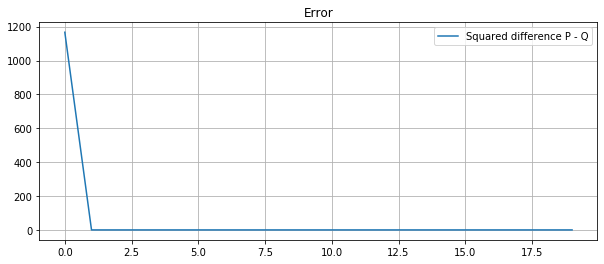

CPU times: user 219 ms, sys: 7.1 ms, total: 226 ms
Wall time: 210 ms


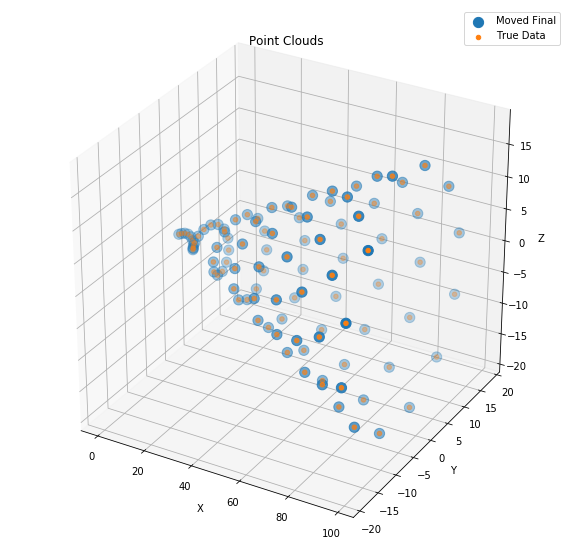

In [47]:
%%time
Pvalues, normValues = ICP(P, Q)
plotValues(normValues, "Squared difference P - Q")
plotData(Pvalues[-1], Q, 'Moved Final', 'True Data', markersize1 = 105)

### Ten Thousand 

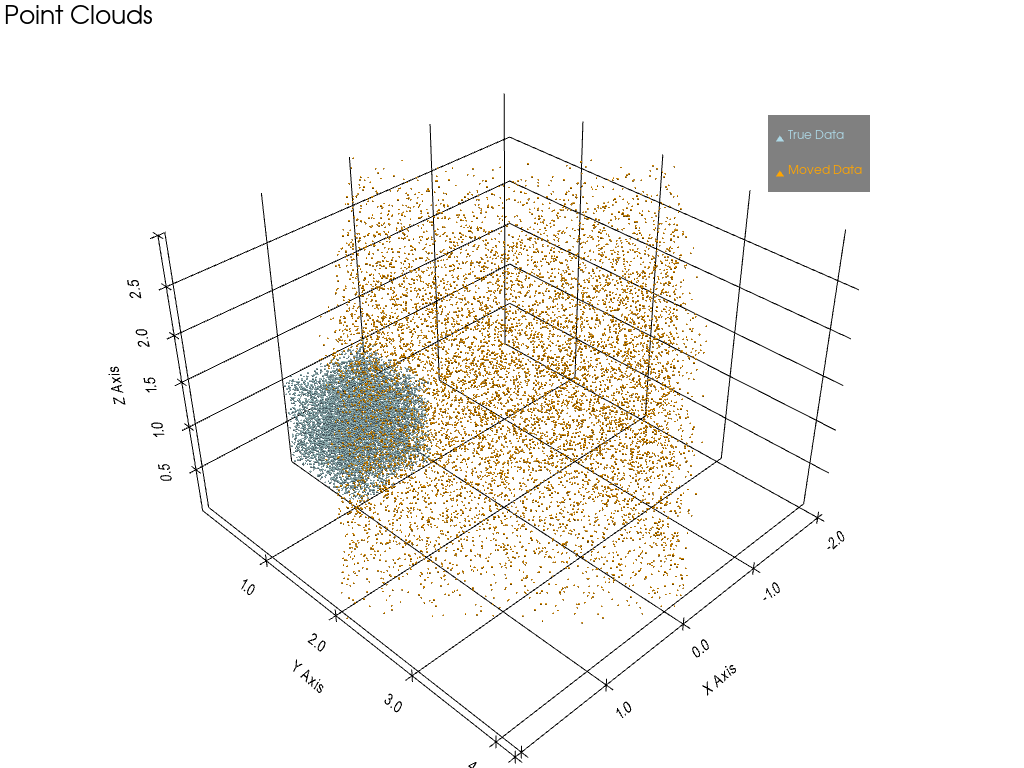

In [38]:
'''Assign data to point clouds P and Q'''
angle = [0, 0, pi/4]
scale = 3
shift = np.array([[0], [0], [0]])
Q, P = generateData(10000, angle, shift, scale)

bigPlot(P, Q, 2, 2)

Iteration: 100%|██████████| 20/20 [00:00<00:00, 333.00it/s]


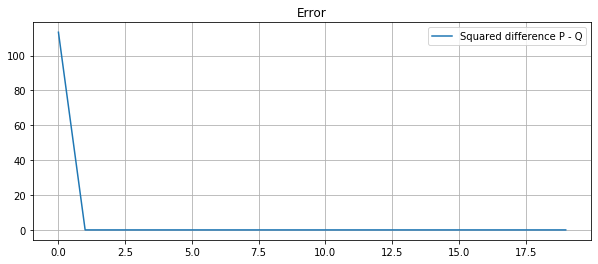

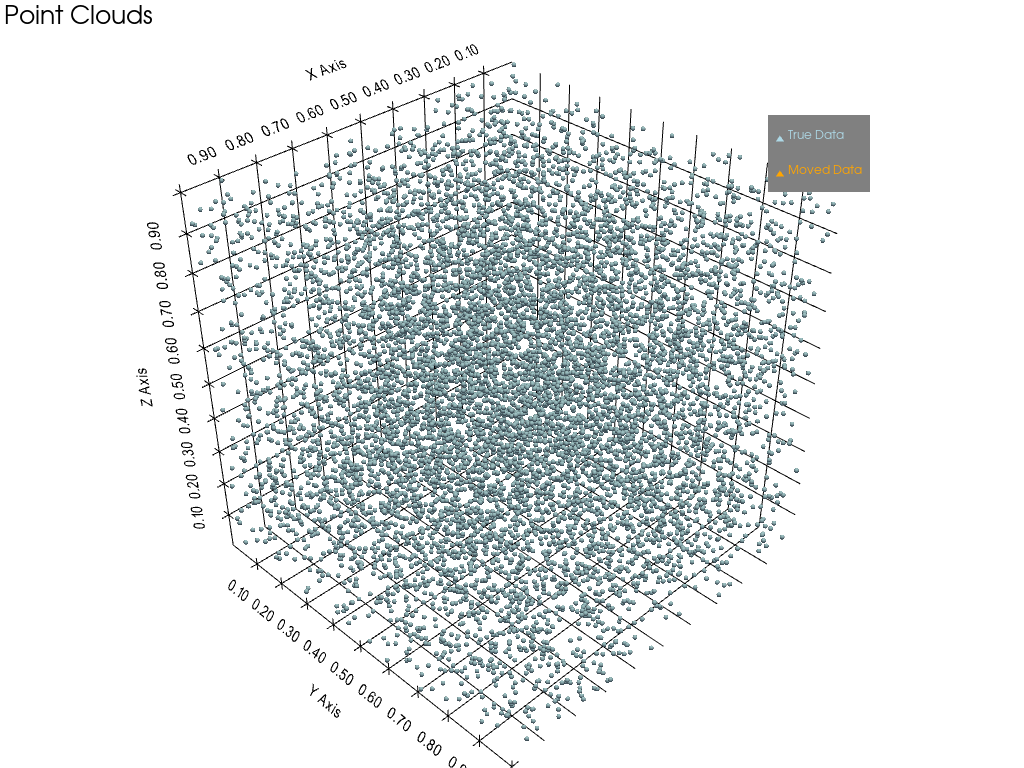

CPU times: user 1.09 s, sys: 722 ms, total: 1.81 s
Wall time: 531 ms


In [39]:
%%time
Pvalues, normValues = ICP(P, Q)
plotValues(normValues, "Squared difference P - Q")
bigPlot(Pvalues[-1], Q, 5, 2)

### Ten Lakh

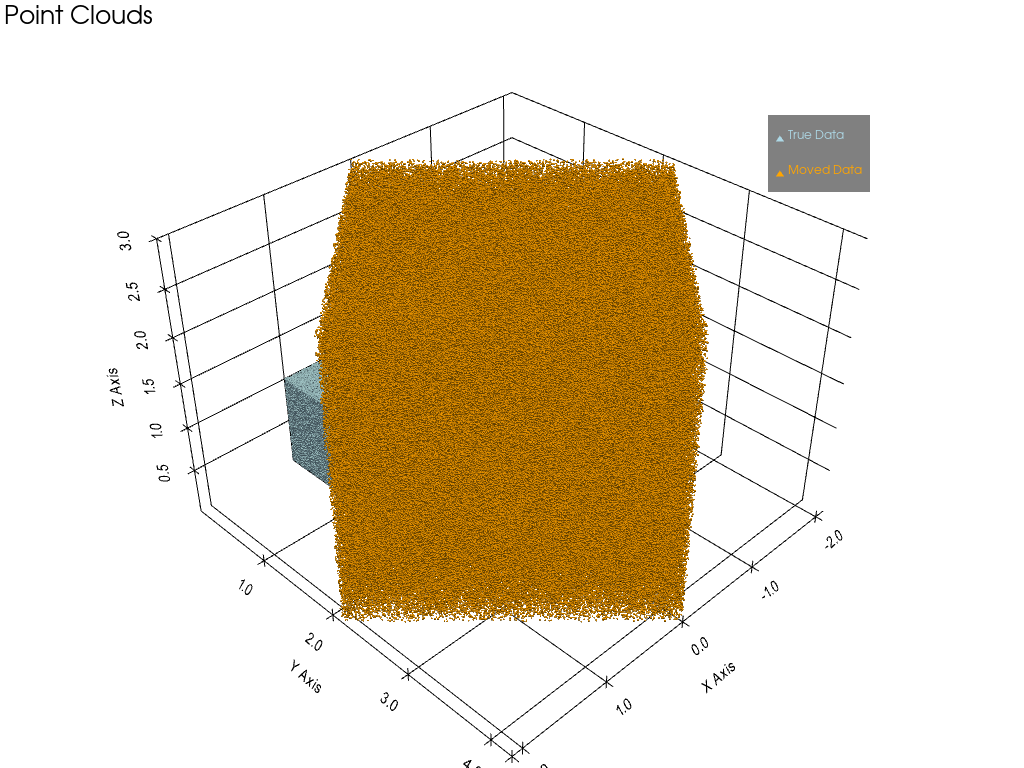

In [40]:
'''Assign data to point clouds P and Q'''
angle = [0, 0, pi/4]
scale = 3
shift = np.array([[0], [0], [0]])
Q, P = generateData(1000000, angle, shift, scale)

bigPlot(P, Q, 2, 2)

Iteration: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]


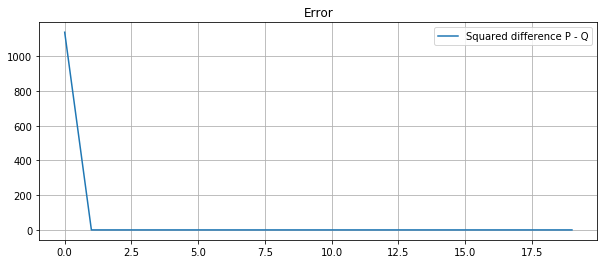

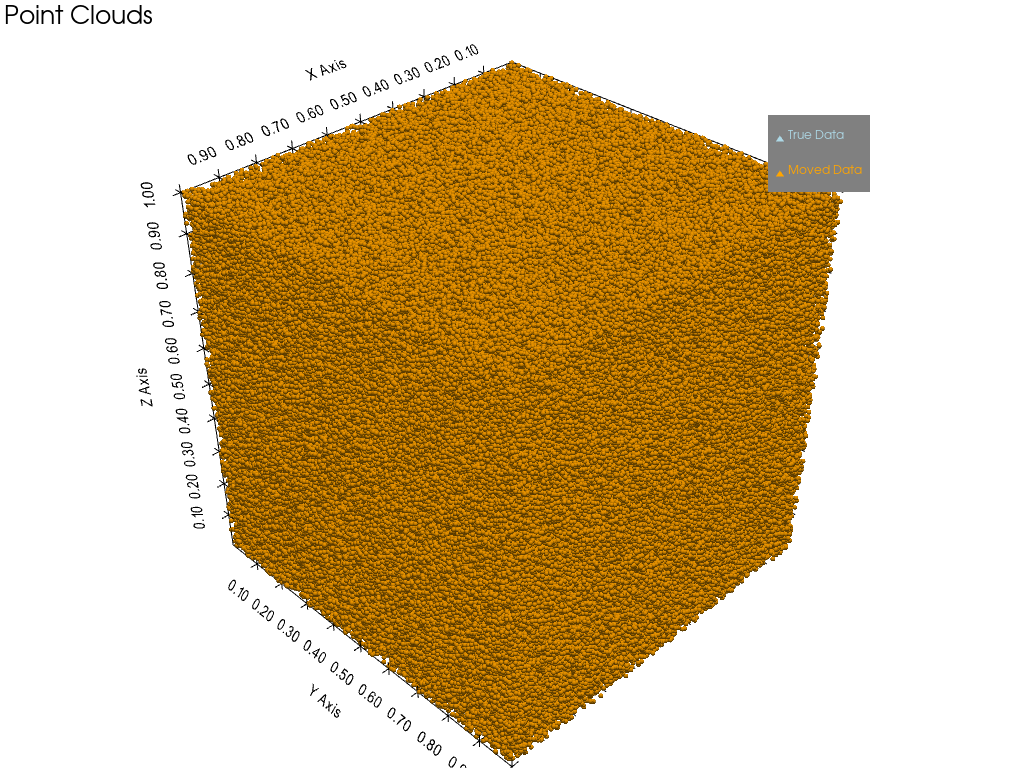

CPU times: user 16.2 s, sys: 11.8 s, total: 28.1 s
Wall time: 4.51 s


In [41]:
%%time
Pvalues, normValues = ICP(P, Q)
plotValues(normValues, "Squared difference P - Q")
bigPlot(Pvalues[-1], Q, 5, 5)

### Redwood

In [14]:
import open3d as o3d

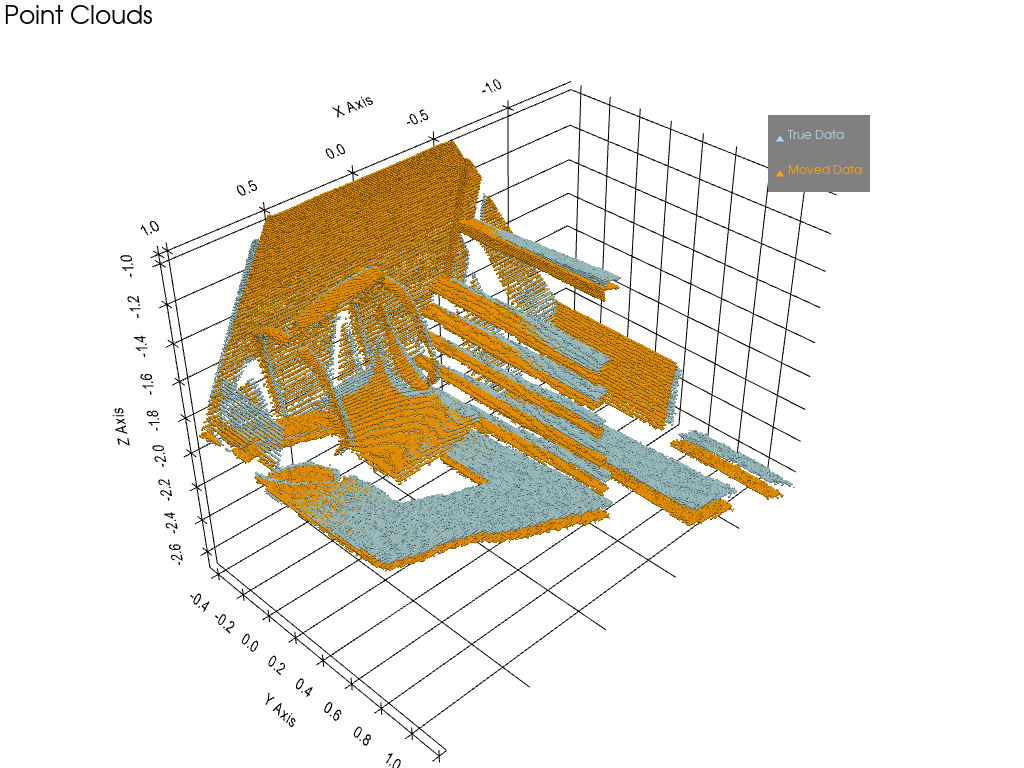

In [44]:
rawColor = o3d.io.read_image("Dataset/00000.jpg")
rawDepth = o3d.io.read_image("Dataset/00000.png")

rgbdImage = o3d.geometry.RGBDImage.create_from_color_and_depth(rawColor, rawDepth)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
         rgbdImage,
         o3d.camera.PinholeCameraIntrinsic(
         o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))

pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

P = np.array(np.asarray(pcd.points)).T

rawColor = o3d.io.read_image("Dataset/00004.jpg")
rawDepth = o3d.io.read_image("Dataset/00004.png")

rgbdImage = o3d.geometry.RGBDImage.create_from_color_and_depth(rawColor, rawDepth)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbdImage,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

Q = np.array(np.asarray(pcd.points)).T
minPoints =  min(P.shape[1], Q.shape[1])
P, Q = P[:, :minPoints], Q[:, :minPoints]

bigPlot(P, Q, 2, 2)

Iteration: 100%|██████████| 20/20 [00:01<00:00, 16.21it/s]


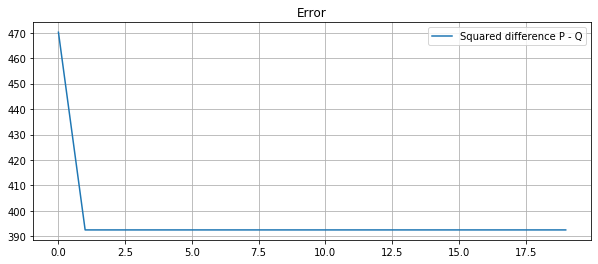

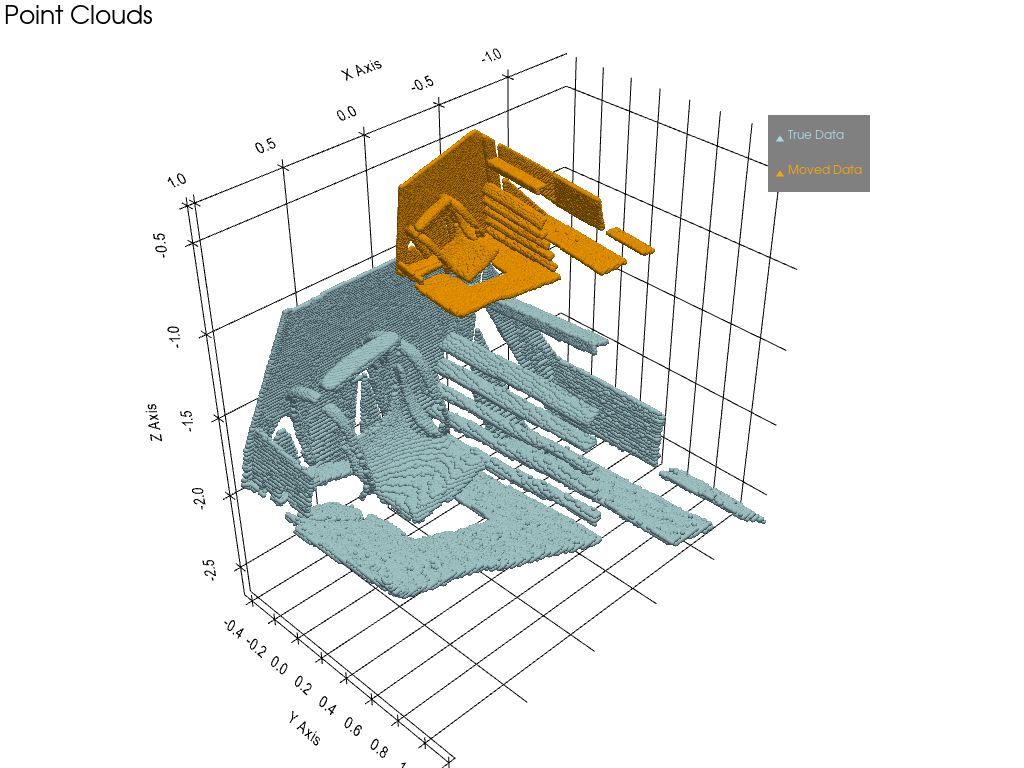

CPU times: user 5.99 s, sys: 4.9 s, total: 10.9 s
Wall time: 1.96 s


In [45]:
%%time
Pvalues, normValues = ICP(P, Q)
plotValues(normValues, "Squared difference P - Q")
bigPlot(Pvalues[-1], Q, 5, 5)

### Room Dataset

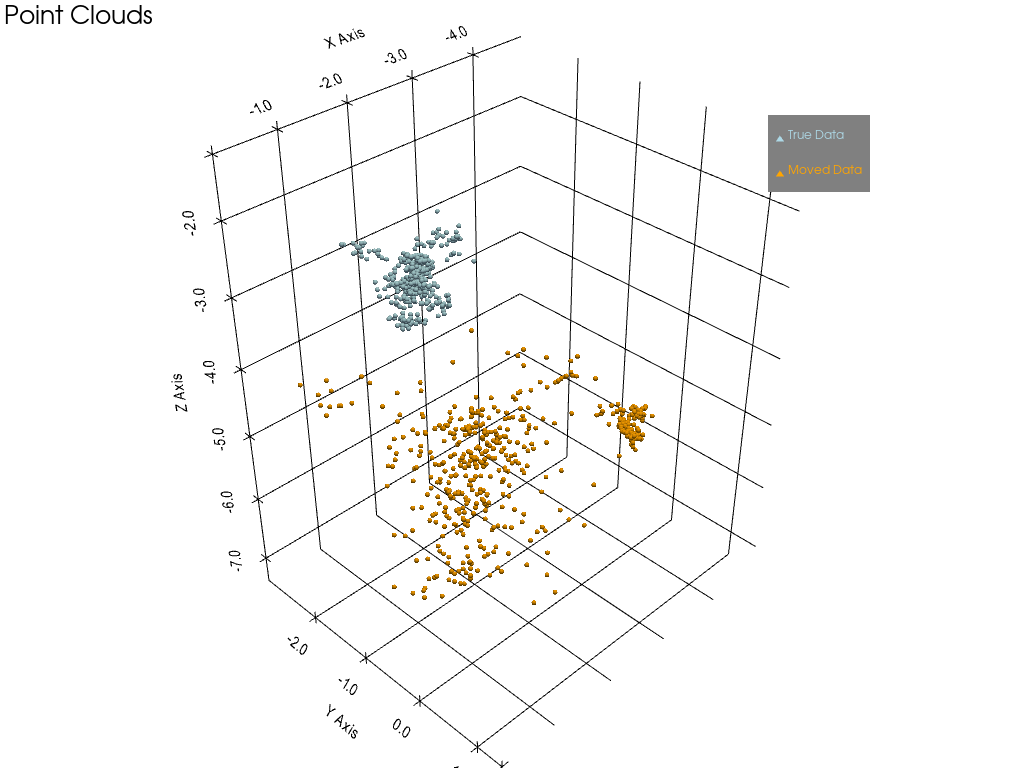

In [42]:
sourceload = o3d.io.read_point_cloud("ply/roomOne.ply")
Q = np.asarray(sourceload.points).T

destinationload = o3d.io.read_point_cloud("ply/roomTwo.ply")
P = np.asarray(destinationload.points).T
P = P*3
bigPlot(P, Q, 5, 5)

Iteration: 100%|██████████| 20/20 [00:00<00:00, 2051.41it/s]


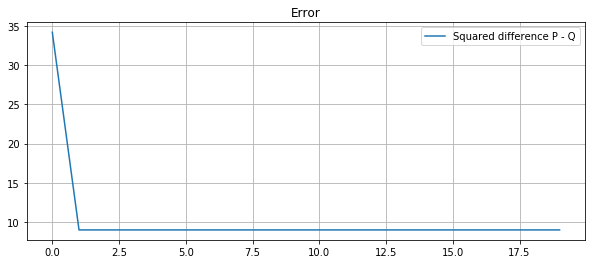

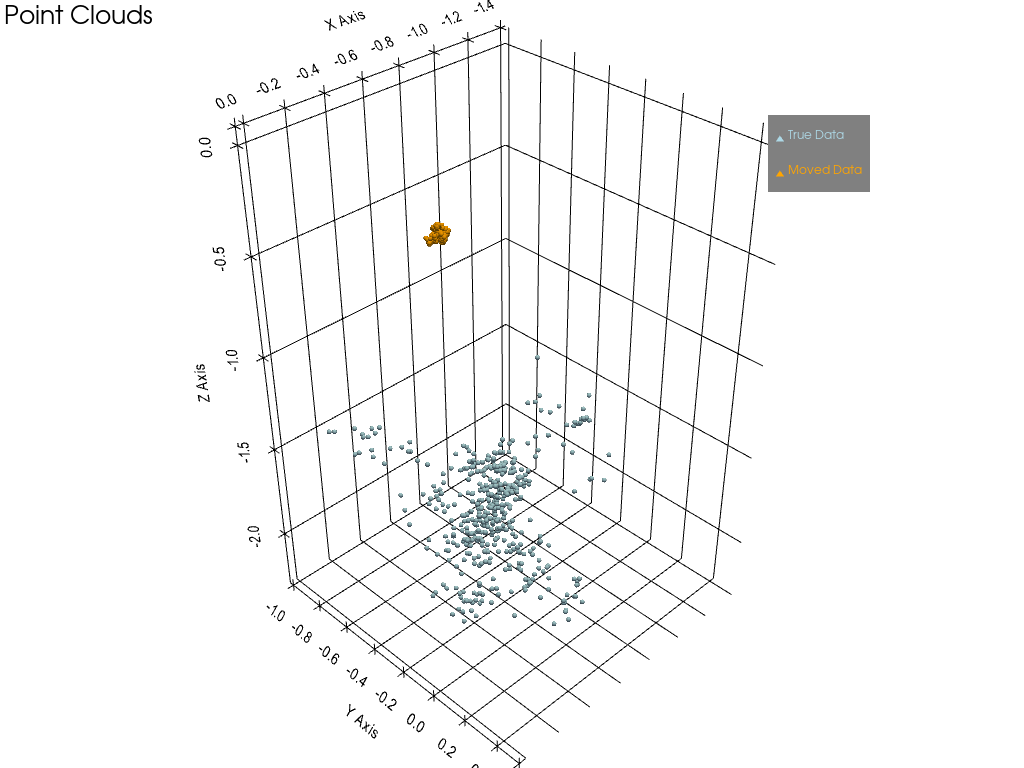

CPU times: user 342 ms, sys: 18.9 ms, total: 361 ms
Wall time: 360 ms


In [43]:
%%time
Pvalues, normValues = ICP(P, Q)
plotValues(normValues, "Squared difference P - Q")
bigPlot(Pvalues[-1], Q, 5, 5)